In [14]:

!pip install sk-video>=1.1.8
import os
if not os.path.exists('vehicle_count.mp4'):
    !wget https://learnml.s3.eu-north-1.amazonaws.com/road.mp4

--2020-12-11 06:05:46--  https://learnml.s3.eu-north-1.amazonaws.com/road.mp4
Resolving learnml.s3.eu-north-1.amazonaws.com (learnml.s3.eu-north-1.amazonaws.com)... 52.95.170.40
Connecting to learnml.s3.eu-north-1.amazonaws.com (learnml.s3.eu-north-1.amazonaws.com)|52.95.170.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191816449 (183M) [video/mp4]
Saving to: ‘road.mp4.1’

road.mp4.1          100%[===================>] 182.93M  10.7MB/s    in 19s     

2020-12-11 06:06:06 (9.63 MB/s) - ‘road.mp4.1’ saved [191816449/191816449]



In [15]:
# import needed modules  

import os
import csv
import numpy as np
import logging
import logging.handlers
import math
import sys
import random
import numpy as np
import skvideo.io
import cv2
import matplotlib.pyplot as plt

from IPython.display import HTML
from base64 import b64encode
cv2.ocl.setUseOpenCL(False)
random.seed(123)
#to setup the logging condition
def init_logging(level=logging.INFO):
    main_logger = logging.getLogger()
    for hnd in main_logger.handlers:
        main_logger.removeHandler(hnd)

    formatter = logging.Formatter(
        fmt='%(asctime)s.%(msecs)03d %(levelname)-8s [%(name)s] %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

    handler_stream = logging.StreamHandler(sys.stdout)
    handler_stream.setFormatter(formatter)
    main_logger.addHandler(handler_stream)
    main_logger.setLevel(level)

    return main_logger

Training BG Subtractor...


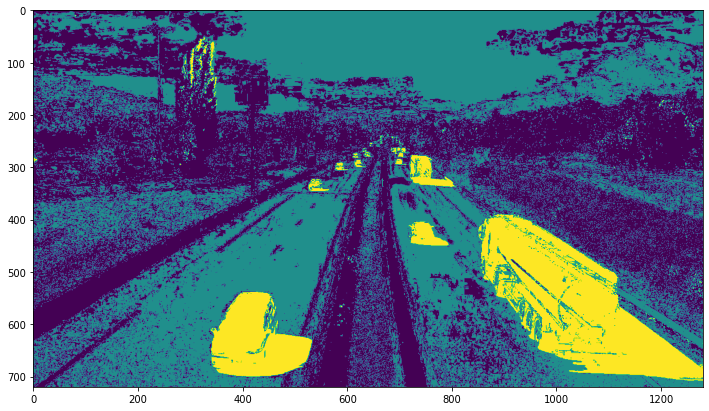

In [16]:
def train_bg_subtractor(inst, cap, num=500):  #Ameya
    #Train BG-Subtractor for some frames
    print ('Training BG Subtractor...')
    i = 0
    for frame in cap:
        inst.apply(frame, None, 0.001)
        i += 1
        if i >= num:
            return cap

VIDEO_SOURCE = "Highway_Traffic.mp4"

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

cap = skvideo.io.vreader(VIDEO_SOURCE)
#skip 500 frames inorder to train
train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
foreground_mask = bg_subtractor.apply(frame, None, 0.001)

plt.figure(figsize=(12,12))
plt.imshow(foreground_mask)
plt.show()

Training BG Subtractor...


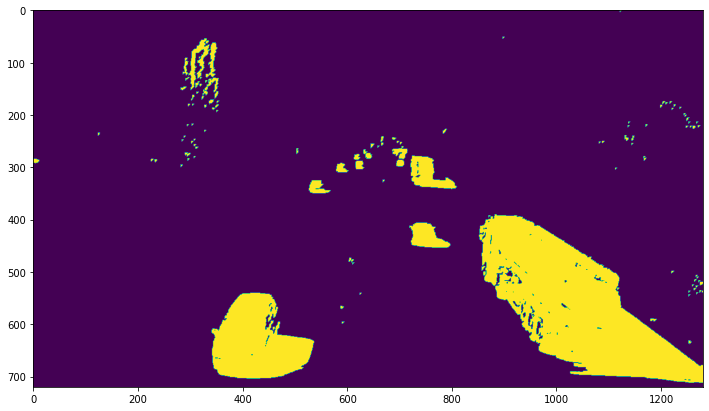

In [17]:
def filter_mask(img):
    

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

    # Fill any small holes
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    # Remove noise
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    # Dilate to merge adjacent blobs
    dilate = cv2.dilate(opening, kernel, iterations=2)

    return dilate

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)
cap = skvideo.io.vreader(VIDEO_SOURCE)


train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
foreground_mask = bg_subtractor.apply(frame, None, 0.001)
foreground_mask[foreground_mask < 240] = 0
foreground_mask = filter_mask(foreground_mask)

plt.figure(figsize=(12,12))
plt.imshow(foreground_mask)
plt.show()

In [18]:
def find_centroid(x, y, w, h):
    #to get the centroid
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)


class ContourDetection:
    

    def __init__(self, bg_subtractor, min_contour_width=35, min_contour_height=35, save_image=False, image_dir='images'):
        super(ContourDetection, self).__init__()

        self.bg_subtractor = bg_subtractor
        self.min_contour_width = min_contour_width
        self.min_contour_height = min_contour_height
        self.save_image = save_image
        self.image_dir = image_dir

    def filter_mask(self, img, a=None):
        

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

      
        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
      
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

      
        dilate = cv2.dilate(opening, kernel, iterations=2)

        return dilate

    def detect_vehicles(self, foreground_mask):

        matches = []

        # inorder to find external contours
        contours, hierarchy = cv2.findContours(
            foreground_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

        for (i, contour) in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            # on exit add some filtering on width and height
            contour_valid = (w >= self.min_contour_width) and (
                h >= self.min_contour_height)

            if not contour_valid:
                continue

            centroid = find_centroid(x, y, w, h)

            matches.append(((x, y, w, h), centroid))

        return matches
    def __call__(self, frame):
        frame = frame.copy()

        foreground_mask = self.bg_subtractor.apply(frame, None, 0.001)
        #set thresholding values
        foreground_mask[foreground_mask < 240] = 0
        foreground_mask = self.filter_mask(foreground_mask, 0)

        return self.detect_vehicles(foreground_mask)

cd = ContourDetection(bg_subtractor)

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)


cap = skvideo.io.vreader(VIDEO_SOURCE)


train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
objects = cd(frame)

print('Getting list of [((x,y,w,h), (xc,yc)), ...]')
print(objects)

Training BG Subtractor...
Getting list of [((x,y,w,h), (xc,yc)), ...]
[((341, 540, 196, 164), (439, 622)), ((719, 406, 79, 48), (758, 430)), ((852, 390, 428, 322), (1066, 551)), ((721, 278, 89, 63), (765, 309)), ((297, 54, 55, 99), (324, 103))]


In [19]:

class PipelineRunner(object):
    

    def __init__(self, pipeline=None, log_level=logging.INFO):
        self.pipeline = pipeline or []
        self.context = {}
        self.log = logging.getLogger(self.__class__.__name__)
        self.log.setLevel(log_level)
        self.log_level = log_level
        self.set_log_level()

    def set_context(self, data):
        self.context = data

    def add(self, processor):
        if not isinstance(processor, PipelineProcessor):
            raise Exception(
                'Processor should be an isinstance of PipelineProcessor.')
        processor.log.setLevel(self.log_level)
        self.pipeline.append(processor)

    def remove(self, name):
        for i, p in enumerate(self.pipeline):
            if p.__class__.__name__ == name:
                del self.pipeline[i]
                return True
        return False

    def set_log_level(self):
        for p in self.pipeline:
            p.log.setLevel(self.log_level)

    def run(self):
        for p in self.pipeline:
            self.context = p(self.context)

        self.log.debug("Frame #%d processed.", self.context['frame_number'])

        return self.context


class PipelineProcessor(object):
    

    def __init__(self):
        self.log = logging.getLogger(self.__class__.__name__)

In [20]:
def save_frame(frame, file_name, flip=True):
    
    if flip:
        cv2.imwrite(file_name, np.flip(frame, 2))
    else:
        cv2.imwrite(file_name, frame)

class ContourDetection(PipelineProcessor):
    #Detecting moving objects

    def __init__(self, bg_subtractor, min_contour_width=35, min_contour_height=35, save_image=False, image_dir='images'):
        super(ContourDetection, self).__init__()

        self.bg_subtractor = bg_subtractor
        self.min_contour_width = min_contour_width
        self.min_contour_height = min_contour_height
        self.save_image = save_image
        self.image_dir = image_dir

    def filter_mask(self, img, a=None):
        

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        
        dilate = cv2.dilate(opening, kernel, iterations=2)

        return dilate

    def detect_vehicles(self, foreground_mask, context):

        matches = []

        # to find external contours
        contours, hierarchy = cv2.findContours(
            foreground_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

        for (i, contour) in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            contour_valid = (w >= self.min_contour_width) and (
                h >= self.min_contour_height)

            if not contour_valid:
                continue

            centroid = find_centroid(x, y, w, h)

            matches.append(((x, y, w, h), centroid))

        return matches

    def __call__(self, context):
        frame = context['frame'].copy()
        frame_number = context['frame_number']

        foreground_mask = self.bg_subtractor.apply(frame, None, 0.001)
        # set thresholding values
        foreground_mask[foreground_mask < 240] = 0
        foreground_mask = self.filter_mask(foreground_mask, frame_number)

        if self.save_image:
            save_frame(foreground_mask, self.image_dir +
                             "/mask_%04d.png" % frame_number, flip=False)

        context['objects'] = self.detect_vehicles(foreground_mask, context)
        context['foreground_mask'] = foreground_mask

        return context


In [21]:
def distance(x, y, type='euclidian', x_weight=1.0, y_weight=1.0):
    if type == 'euclidian':
        return math.sqrt(float((x[0] - y[0])**2) / x_weight + float((x[1] - y[1])**2) / y_weight)


class VehicleCounter(PipelineProcessor):
    

    def __init__(self, exit_masks=[], path_size=10, max_dst=30, x_weight=1.0, y_weight=1.0):
        super(VehicleCounter, self).__init__()

        self.exit_masks = exit_masks

        self.vehicle_count = 0
        self.path_size = path_size
        self.pathes = []
        self.max_dst = max_dst
        self.x_weight = x_weight
        self.y_weight = y_weight

    def check_exit(self, point):
        for exit_mask in self.exit_masks:
            try:
                if exit_mask[point[1]][point[0]] == 255:
                    return True
            except:
                return True
        return False

    def __call__(self, context):
        objects = context['objects']
        context['exit_masks'] = self.exit_masks
        context['pathes'] = self.pathes
        context['vehicle_count'] = self.vehicle_count
        if not objects:
            return context

        points = np.array(objects)[:, 0:2]
        points = points.tolist()
        #print(points)

       
        if not self.pathes:
            for match in points:
                self.pathes.append([match])

        else:
           #link new with old with minimum distance
            new_pathes = []

            for path in self.pathes:
                _min = 999999
                _match = None
                for p in points:
                    if len(path) == 1:
                        
                        d = distance(p[0], path[-1][0])
                    else:
                       #calculate next point based on previous and then measure distance
                        xn = 2 * path[-1][0][0] - path[-2][0][0]
                        yn = 2 * path[-1][0][1] - path[-2][0][1]
                        d = distance(
                            p[0], (xn, yn),
                            x_weight=self.x_weight,
                            y_weight=self.y_weight
                        )

                    if d < _min:
                        _min = d
                        _match = p

                if _match and _min <= self.max_dst:
                    points.remove(_match)
                    path.append(_match)
                    new_pathes.append(path)

               
                if _match is None:
                    new_pathes.append(path)

            self.pathes = new_pathes

            
            if len(points):
                for p in points:
                   
                    if self.check_exit(p[1]):
                        continue
                    self.pathes.append([p])
        
        # save only last N points in path
        for i, _ in enumerate(self.pathes):
            self.pathes[i] = self.pathes[i][self.path_size * -1:]

        # count vehicles and drop counted pathes:
        new_pathes = []
        for i, path in enumerate(self.pathes):
            d = path[-2:]

            if (
               
                len(d) >= 2 and
               
                not self.check_exit(d[0][1]) and
               
                self.check_exit(d[1][1]) and
               
                self.path_size <= len(path)
            ):
                self.vehicle_count += 1
            else:
               
                add = True
                for p in path:
                    if self.check_exit(p[1]):
                        add = False
                        break
                if add:
                    new_pathes.append(path)

        self.pathes = new_pathes

        context['pathes'] = self.pathes
        context['objects'] = objects
        context['vehicle_count'] = self.vehicle_count

        self.log.debug('#VEHICLES FOUND: %s' % self.vehicle_count)

        return context



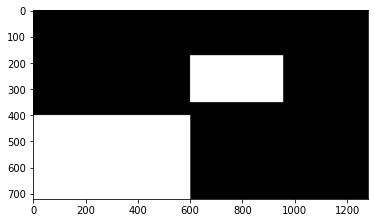

In [22]:
EXIT_PTS = np.array([  [[0, 400], [0, 732], [600, 732], [600, 400]],
                     [[600, 172], [600, 350], [955, 350] ,[955, 172]]
                    
])
  
     
SHAPE = (720,1280)
base = np.zeros(SHAPE + (3,), dtype='uint8')
exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

plt.imshow(base)
plt.show()

In [23]:
class CsvWriter(PipelineProcessor):
  #write to csv file generated

    def __init__(self, path, name, start_time=0, fps=15):
        super(CsvWriter, self).__init__()

        self.fp = open(os.path.join(path, name), 'w')
        self.writer = csv.DictWriter(self.fp, fieldnames=['time', 'vehicles'])
        self.writer.writeheader()
        self.start_time = start_time
        self.fps = fps
        self.path = path
        self.name = name
        self.prev = None

    def __call__(self, context):
        frame_number = context['frame_number']
        count = _count = context['vehicle_count']

        if self.prev:
            _count = count - self.prev

        time = ((self.start_time + int(frame_number / self.fps)) * 100 
                + int(100.0 / self.fps) * (frame_number % self.fps))
        self.writer.writerow({'time': time, 'vehicles': _count})
        self.prev = count

        return context

BOUNDING_BOX_COLOUR = (255, 192, 0)
CENTROID_COLOUR = (255, 192, 0)
CAR_COLOURS = [(255, 192, 0)]
EXIT_COLOR = (66, 183, 42)

class Visualizer(PipelineProcessor):

    def __init__(self, save_image=True, image_dir='images'):
        super(Visualizer, self).__init__()

        self.save_image = save_image
        self.image_dir = image_dir

    def check_exit(self, point, exit_masks=[]):
        for exit_mask in exit_masks:
            if exit_mask[point[1]][point[0]] == 255:
                return True
        return False

    def draw_pathes(self, img, pathes):
        if not img.any():
            return

        for i, path in enumerate(pathes):
            path = np.array(path)[:, 1].tolist()
            for point in path:
                cv2.circle(img, point, 2, CAR_COLOURS[0], -1)
                cv2.polylines(img, [np.int32(path)], False, CAR_COLOURS[0], 1)

        return img

    def draw_boxes(self, img, pathes, exit_masks=[]):
        for (i, match) in enumerate(pathes):

            contour, centroid = match[-1][:2]
            if self.check_exit(centroid, exit_masks):
                continue

            x, y, w, h = contour

            cv2.rectangle(img, (x, y), (x + w - 1, y + h - 1),
                          BOUNDING_BOX_COLOUR, 1)
            cv2.circle(img, centroid, 2, CENTROID_COLOUR, -1)

        return img

    def draw_ui(self, img, vehicle_count, exit_masks=[]):

      
        for exit_mask in exit_masks:
            _img = np.zeros(img.shape, img.dtype)
            _img[:, :] = EXIT_COLOR
            mask = cv2.bitwise_and(_img, _img, mask=exit_mask)
            cv2.addWeighted(mask, 1, img, 1, 0, img)

        # drawing top block with vehicle count
        cv2.rectangle(img, (0, 0), (img.shape[1], 50), (0, 0, 0), cv2.FILLED)
        cv2.putText(img, ("Vehicles passed: {total} ".format(total=vehicle_count)), (30, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
        return img

    def __call__(self, context):
        frame = context['frame'].copy()
        frame = np.ascontiguousarray(np.flip(frame, 2))
        frame_number = context['frame_number']
        pathes = context['pathes']
        exit_masks = context['exit_masks']
        vehicle_count = context['vehicle_count']

        frame = self.draw_ui(frame, vehicle_count, exit_masks)
        frame = self.draw_pathes(frame, pathes)
        frame = self.draw_boxes(frame, pathes, exit_masks)
        if self.save_image:
            save_frame(frame, self.image_dir +
                            "/processed_%04d.png" % frame_number)

        context['frame'] = frame
        return context

In [24]:
# build runner
def main():
    log = logging.getLogger("main")

    
    base = np.zeros(SHAPE + (3,), dtype='uint8')
    exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

   
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

    
    pipeline = PipelineRunner(pipeline=[
        ContourDetection(bg_subtractor=bg_subtractor,
                         save_image=True, image_dir=IMAGE_DIR),
        
        VehicleCounter(exit_masks=[exit_mask], y_weight=2.0),
        Visualizer(image_dir=IMAGE_DIR,save_image=False),
        CsvWriter(path='./', name='report.csv')
    ], log_level=logging.INFO)

  
    cap = skvideo.io.vreader(VIDEO_SOURCE)

  
    train_bg_subtractor(bg_subtractor, cap, num=500)

    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    writer = cv2.VideoWriter(VIDEO_OUT, fourcc, 25, (SHAPE[1], SHAPE[0]), True)

    frame_number = -1
    for frame in cap:
        if not frame.any():
            log.error("Frame capture failed, stopping...")
            break

        frame_number += 1
        log.info("Frame #%s" % frame_number)

        pipeline.set_context({
            'frame': frame,
            'frame_number': frame_number,
        })
        ctx = pipeline.run()
        writer.write(ctx['frame'])

        if frame_number > PARSE_FRAMES:
            break
    writer.release()

In [25]:
# Parameters
# ============================================================================
IMAGE_DIR = "images"
VIDEO_SOURCE = "Highway_Traffic.mp4"
VIDEO_OUT = "final_output.mp4"
PARSE_FRAMES = 15*25
SHAPE = (720, 1280)  # HxW
EXIT_PTS = np.array([  [[0, 400], [0, 732], [600, 732], [600, 400]],
                     [[600, 172], [600, 350], [955, 350] ,[955, 172]]
                    
])
  
# ============================================================================

log = init_logging()
main()

Training BG Subtractor...
2020-12-11 06:07:27.398 INFO     [main] Frame #0
2020-12-11 06:07:27.488 INFO     [main] Frame #1
2020-12-11 06:07:27.573 INFO     [main] Frame #2
2020-12-11 06:07:27.663 INFO     [main] Frame #3
2020-12-11 06:07:27.746 INFO     [main] Frame #4
2020-12-11 06:07:27.828 INFO     [main] Frame #5
2020-12-11 06:07:27.912 INFO     [main] Frame #6
2020-12-11 06:07:28.002 INFO     [main] Frame #7
2020-12-11 06:07:28.089 INFO     [main] Frame #8
2020-12-11 06:07:28.171 INFO     [main] Frame #9
2020-12-11 06:07:28.254 INFO     [main] Frame #10
2020-12-11 06:07:28.343 INFO     [main] Frame #11
2020-12-11 06:07:28.423 INFO     [main] Frame #12
2020-12-11 06:07:28.505 INFO     [main] Frame #13
2020-12-11 06:07:28.586 INFO     [main] Frame #14
2020-12-11 06:07:28.667 INFO     [main] Frame #15
2020-12-11 06:07:28.746 INFO     [main] Frame #16
2020-12-11 06:07:28.820 INFO     [main] Frame #17
2020-12-11 06:07:28.898 INFO     [main] Frame #18
2020-12-11 06:07:28.977 INFO     [

In [26]:
from google.colab import files
files.download('final_output.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>